# Introduction

Given samples of marginals $X\sim \mu$ and $Y \sim \nu$, we would like to find the solution of the Monge-Kantorovich problem
\begin{eqnarray}
\label{eq:pi_opt}
\pi^{\textrm{opt}}_{\mu,\nu}&:=& argmin_{\pi\in\Pi(\mu,\nu)}\int_{\mathbb{R}^{n}\times \mathbb{R}^{n}} c(x,y)\pi(dx,dy)
\end{eqnarray}
with $c:\mathbb{R}^{2n}\to\mathbb{R}$ as a non-negative smooth function. In this work, we use the orthogonal coupling dynamics of the form

\begin{eqnarray}
\label{eq:main-ODE}
\dot{X}_t=-\nabla_x c(X_t,Y_t)+\mathbb{E}_{p_t}[\nabla_x c(X_t,Y_t)|X_t] \nonumber \\
\textrm{and} \ \ \ \ \dot{Y}_t=-\nabla_y c(X_t,Y_t)+\mathbb{E}_{p_t}[\nabla_y c(X_t,Y_t)|Y_t].
\end{eqnarray}

In this notebook, we present an implementation of OCD and test it in a few examples.

# Implementation of OCD
Here, we load the necessary libraries and implement the OCD algorithm.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance as wd
import time
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [2]:
from sklearn.neighbors import BallTree
from sklearn.cluster import DBSCAN

def rangesearch(x, e):
    ## This function is used to find particle ids within a radius e
    tree = BallTree(x)
    ind = tree.query_radius(x, r=e)
    return ind

def compute_cond(idx, y):
    ## This function computes piecewise constant approximation to the conditional expectation  
    # Flatten idx and create an offset array
    flat_idx = np.concatenate(idx)
    lens = [len(i) for i in idx]

    # Use np.add.reduceat to sum the elements
    sums = np.add.reduceat(y[flat_idx], np.r_[0, np.cumsum(lens[:-1])])

    avg = sums/np.array(lens)[:,None]
    
    return avg

def compute_cond_vectorized_no_loop(X_m, Y_m, Idx_m, NparticleThreshold = 4):
    ## This function computes piecewise linear approximation to the conditional expectation

    # Flatten idx_m and create an offset array
    flat_idx = np.concatenate(Idx_m)
    lens = np.array([len(i) for i in Idx_m])

    # Repeating indices for broadcasting
    repeats = np.repeat(np.arange(len(Idx_m)), lens)
    
    # Calculate the means for each group
    X_m_means = np.add.reduceat(X_m[flat_idx], np.r_[0, np.cumsum(lens[:-1])]) / lens[:, None]
    Y_m_means = np.add.reduceat(Y_m[flat_idx], np.r_[0, np.cumsum(lens[:-1])]) / lens[:, None]
    
    # Initialize the result array with Y_m_means
    y_Cond_x_m = Y_m_means.copy()

    # Handle cases with more than one neighbor
    valid_idx = lens > NparticleThreshold

    if np.any(valid_idx):
        # Centering X_m and Y_m for valid indices
        X_m_centered = X_m[flat_idx] - X_m_means[repeats]
        Y_m_centered = Y_m[flat_idx] - Y_m_means[repeats]
        
        # Compute J_idx and sigma_x for valid indices
        J_idx = np.add.reduceat(X_m_centered[:, :, None] * Y_m_centered[:, None, :], np.r_[0, np.cumsum(lens[:-1])]) / lens[:, None, None]
        sigma_x = np.add.reduceat(X_m_centered[:, :, None] * X_m_centered[:, None, :], np.r_[0, np.cumsum(lens[:-1])]) / lens[:, None, None]
        
        # Inverse of sigma_x (using pseudo-inverse to handle singular matrices)
        sigma_x_inv = np.linalg.pinv(sigma_x[valid_idx])

        # Compute X_m difference for valid indices
        X_m_diff = X_m[valid_idx] - X_m_means[valid_idx]
        
        # Compute the conditional expectations y_Cond_x for valid indices
        y_Cond_x_m[valid_idx] = Y_m_means[valid_idx] + np.einsum('ijk,ik->ij', J_idx[valid_idx] @ sigma_x_inv, X_m_diff)

    return y_Cond_x_m


def find_nclusters(x, y, eps):
    ## This function finds the number of clusters using DBSCAN
    # inputs: x: (N,dim),
    #         y: (Np,dim),
    #         eps: bandwidth
    # output: number of clusters
    joint = np.concatenate([x,y],axis=1)
    
    clustering = DBSCAN(eps=1*eps, min_samples=1).fit(joint)

    labels = clustering.labels_

    return len(set(labels)) - (1 if -1 in labels else 0)

    
def find_opt_eps2(X0, Y0, log_eps_range=[-3,1], nepss = 10, perc=0.95):
    ## This function finds the maximum bandwidth epsilon where N_cluster/Np>perc
    # inputs: X0: (N,dim),
    #         Y0: (Np,dim),
    #         log_eps_range: the range to consider for eps in logarithmic scale
    #         nepss: number of grid points
    #         prec: the criteria for finding maximum bandwidth where N_cluster/Np>perc
    # outputs: eps0: the estimated optimal bandwidth
    
    N = X0.shape[0]
    epss = np.logspace(log_eps_range[0],log_eps_range[1],nepss)
    nclusters = np.zeros(nepss)
    for i in range(nepss):
        eps = epss[i]
        X = X0.copy()
        Y = Y0.copy()
        nclusters[i] = find_nclusters(X, Y, eps)
        
        if nclusters[i] < perc*N:
            eps0 = epss[i]
            break
    return eps0
    
def ocd_map(X00, Y00, dt=0.01, Nt=1000, sigma=0.1, epsX=None, epsY=None, tol=1e-14, minNt = 100, NparticleThreshold=10):
    ## This function finds the map between X and Y by solving OCD dynamics using Euler method
    # inputs: X: (N,dim),
    #         Y: (Np,dim),
    #         dt: time step size,
    #         Nt: number of steps
    #         sigma: the kernel bandwidth for computing conditional expectation
    #         tol: convergence tolerance
    #         minNt: minimum number of iterations
    #         NparticleThreshold: number of particles as the threshold to switch between 
    #                             piecewse constant and linear approximation of conditional expectation
    # outputs: X (N,dim),
    #          Y (Np,dim)
    #          dists: history of W2 distance
    #          err_m2X, err_m2Y: history of the error in 2nd order moments for X and Y
    if epsX is None:
        epsX = sigma
    if epsY is None:
        epsY = sigma
        
    X = X00.copy()
    Y = Y00.copy()
    m2X = np.mean(X00, axis=0)
    m2Y = np.mean(Y00, axis=0)

    np_particles, d = Y.shape

    y_Cond_x = np.zeros_like(X)   # Initialize Y conditional X
    x_Cond_y = np.zeros_like(Y)   # Initialize X conditional Y

    err_m2X = []
    err_m2Y = []
    dists = []
    dists.append(np.mean(np.sum((X - Y) ** 2, axis=1)))
    
    rx = epsX
    ry = epsY
        
    for it in range(Nt):
        if it % 1000 == 0 and it>0:
            print("it: ", it, " dist: ", dists[it])
        err_m2X.append(abs(m2X-np.mean(X, axis=0)))
        err_m2Y.append(abs(m2Y-np.mean(Y, axis=0)))
        
        X0 = X.copy()
        Y0 = Y.copy()

        # Update X and Y
        X = X0 + (Y0 - y_Cond_x) * dt
        Y = Y0 + (X0 - x_Cond_y) * dt

        # Finding neighbors of X in eps
        Idx = rangesearch(X, rx)
        Idy = rangesearch(Y, ry)
        
        y_Cond_x = compute_cond_vectorized_no_loop(X, Y, Idx, NparticleThreshold)
        x_Cond_y = compute_cond_vectorized_no_loop(Y, X, Idy, NparticleThreshold)
        
        ## keep a history of W2 distance
        dists.append(np.mean(np.sum((X - Y) ** 2, axis=1)))
        if it>minNt:
            if abs(dists[it+1]-dists[it]) < tol:
                break
    return X, Y, dists, err_m2X, err_m2Y

def ocd_map_RK4(X00, Y00, dt=0.01, Nt=1000, sigma=0.1, epsX=None, epsY=None, tol=1e-14, minNt = 100, NparticleThreshold=10):
    ## This function finds the map between X and Y by solving OCD dynamics using RK4
    # inputs: X: (N,dim),
    #         Y: (Np,dim),
    #         dt: time step size,
    #         Nt: number of steps
    #         sigma: the kernel bandwidth for computing conditional expectation
    #         tol: convergence tolerance
    #         minNt: minimum number of iterations
    #         NparticleThreshold: number of particles as the threshold to switch between 
    #                             piecewse constant and linear approximation of conditional expectation
    # outputs: X (N,dim),
    #          Y (Np,dim)
    #          dists: history of W2 distance
    #          err_m2X, err_m2Y: history of the error in 2nd order moments for X and Y
    if epsX is None:
        epsX = sigma
    if epsY is None:
        epsY = sigma
        
    X = X00.copy()
    Y = Y00.copy()
    m2X = np.mean(X00, axis=0)
    m2Y = np.mean(Y00, axis=0)

    np_particles, d = Y.shape

    y_Cond_x = np.zeros_like(X)   # Initialize Y conditional X
    x_Cond_y = np.zeros_like(Y)   # Initialize X conditional Y

    err_m2X = []
    err_m2Y = []
    dists = []
    dists.append(np.mean(np.sum((X - Y) ** 2, axis=1)))
    
    rx = epsX
    ry = epsY
        
    for it in range(Nt):
        if it % 1000 == 0 and it>0:
            print("it: ", it, " dist: ", dists[it])
        err_m2X.append(abs(m2X-np.mean(X, axis=0)))
        err_m2Y.append(abs(m2Y-np.mean(Y, axis=0)))
        
        X0 = X.copy()
        Y0 = Y.copy()
        
        k1_X = (Y0 - y_Cond_x) * dt
        k1_Y = (X0 - x_Cond_y) * dt
        X_mid = X0 + 0.5 * k1_X
        Y_mid = Y0 + 0.5 * k1_Y
        Idx_mid = rangesearch(X_mid, rx)
        Idy_mid = rangesearch(Y_mid, ry)
        y_Cond_x_mid = compute_cond_vectorized_no_loop(X_mid, Y_mid, Idx_mid, NparticleThreshold)
        x_Cond_y_mid = compute_cond_vectorized_no_loop(Y_mid, X_mid, Idy_mid, NparticleThreshold)
        k2_X = (Y_mid - y_Cond_x_mid) * dt 
        k2_Y = (X_mid - x_Cond_y_mid) * dt
        X_mid = X0 + 0.5 * k2_X
        Y_mid = Y0 + 0.5 * k2_Y
        Idx_mid = rangesearch(X_mid, rx)
        Idy_mid = rangesearch(Y_mid, ry)
        y_Cond_x_mid = compute_cond_vectorized_no_loop(X_mid, Y_mid, Idx_mid, NparticleThreshold)
        x_Cond_y_mid = compute_cond_vectorized_no_loop(Y_mid, X_mid, Idy_mid, NparticleThreshold)
        k3_X = (Y_mid - y_Cond_x_mid) * dt
        k3_Y = (X_mid - x_Cond_y_mid) * dt
        X_end = X0 + k3_X
        Y_end = Y0 + k3_Y
        Idx_end = rangesearch(X_end, rx)
        Idy_end = rangesearch(Y_end, ry)
        y_Cond_x_end = compute_cond_vectorized_no_loop(X_end, Y_end, Idx_end, NparticleThreshold)
        x_Cond_y_end = compute_cond_vectorized_no_loop(Y_end, X_end, Idy_end, NparticleThreshold)
        k4_X = (Y_end - y_Cond_x_end) * dt
        k4_Y = (X_end - x_Cond_y_end) * dt
        X = X0 + (k1_X + 2*k2_X + 2*k3_X + k4_X) / 6
        Y = Y0 + (k1_Y + 2*k2_Y + 2*k3_Y + k4_Y) / 6
        
        Idx = rangesearch(X, rx)
        Idy = rangesearch(Y, ry)
        y_Cond_x = compute_cond_vectorized_no_loop(X, Y, Idx, NparticleThreshold) 
        x_Cond_y = compute_cond_vectorized_no_loop(Y, X, Idy, NparticleThreshold)
        
        ## keep a history of W2 distance
        dists.append(np.mean(np.sum((X - Y) ** 2, axis=1)))
        if it>minNt:
            if abs(dists[it+1]-dists[it]) < tol:
                break
    return X, Y, dists, err_m2X, err_m2Y

# Example: Learning a map between Gaussian and Swiss Roll
In this section, we generate samples of Gaussian and Swiss roll and find the optimal map between them using OCD. Then, we train a Neural Network on the paired samples as the learned map.

First we generate samples of $X\sim \mathcal{N}(0,1)$ and $Y\sim f^{Swiss-roll}$: 

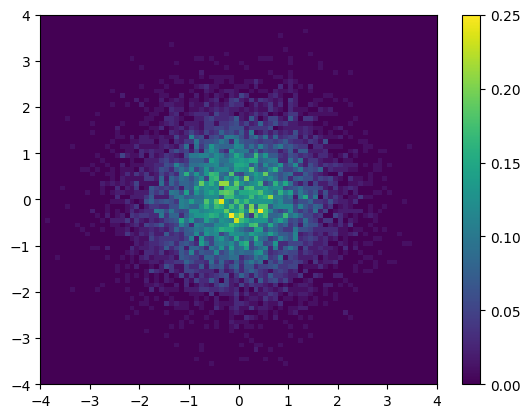

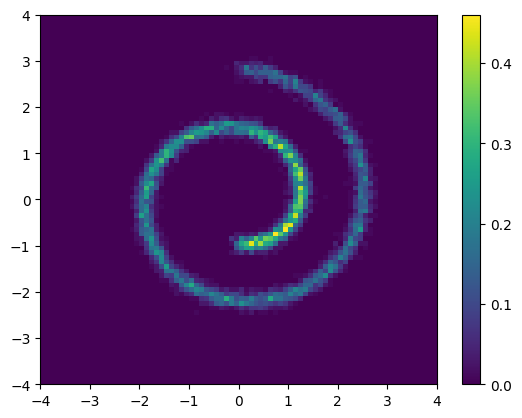

In [48]:
def swissroll(n=1000, noise=0.5):
    """
    Generate samples of a 2D Swiss roll distribution.

    Parameters:
    n (int)     : Number of points to generate (default: 1000)
    noise (float): Amount of Gaussian noise to add (default: 0.05)

    Returns:
    X (ndarray)  : An n x 2 matrix, where each row is a point (x, y) in 2D space
    """
    # Generate random values for the angle (theta) and height (z)
    theta = (3 * np.pi / 2) * (1 + 2 * np.random.rand(n, 1))  # Angle (theta) values for the spiral

    # Generate the (x, y) coordinates
    x = theta * np.cos(theta)
    y = theta * np.sin(theta)

    # Add Gaussian noise
    x += noise * np.random.randn(n, 1)
    y += noise * np.random.randn(n, 1)

    # Combine the coordinates into a matrix X
    X = np.hstack((x / 5., y / 5.))  # Dividing by 5 to match the scale

    return X

Np = 10**4 # number of points/particles/samples
dim = 2

X = np.random.normal(0,1,(Np,dim))
Y = swissroll(Np)

## store samples for future use
Y00 = Y.copy()
X00 = X.copy()

## plot histogram of generated samples
plt.figure()
_ = plt.hist2d(X[:,0],X[:,1],bins=80, density=True, range=[[-4,4],[-4,4]])
plt.colorbar()

plt.figure()
_ = plt.hist2d(Y[:,0],Y[:,1],bins=80, density=True, range=[[-4,4],[-4,4]])
plt.colorbar()

Then, we solve OCD dynamics for this problem. To do so, first we get an estimate for the optimal bandwidth $\epsilon$, and then call RK4 solver to find the OCD estimate of the optimal map.

epsilon =  0.029763514416313176


Text(0.5, 0, 'Iteration')

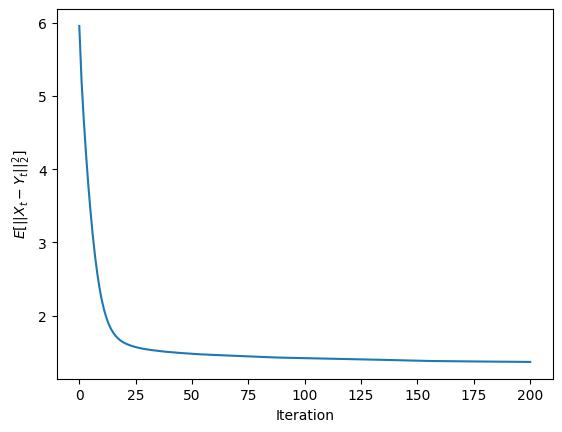

In [42]:
X0 = X00.copy()
Y0 = Y00.copy()

eps0 = find_opt_eps2(X0, Y0, log_eps_range=[-3,0], nepss = 400, perc=0.9998)
print("epsilon = ", eps0)

dt = 0.1
Nt = 200
tol = 1e-6

X_ocd, Y_ocd, dists, err_m2X, err_m2Y = ocd_map_RK4(X0, Y0, dt=dt, Nt=200, sigma=eps0, tol=tol)

plt.figure()
plt.plot(dists)
plt.ylabel(r"$E[||X_t-Y_t||_2^2]$")
plt.xlabel("Iteration")   

Now that have found paired particles $(X^*,Y^*)$, we train a network as a super-wise learning.

Epoch 1000, Loss: 0.4656559228897095
Epoch 2000, Loss: 0.3891581892967224
Epoch 3000, Loss: 0.2785191237926483
Epoch 4000, Loss: 0.1863144487142563
Epoch 5000, Loss: 0.12092949450016022
Epoch 6000, Loss: 0.07843795418739319
Epoch 7000, Loss: 0.06786017119884491
Epoch 8000, Loss: 0.04439731314778328
Epoch 9000, Loss: 0.055268578231334686
Epoch 10000, Loss: 0.02958206832408905


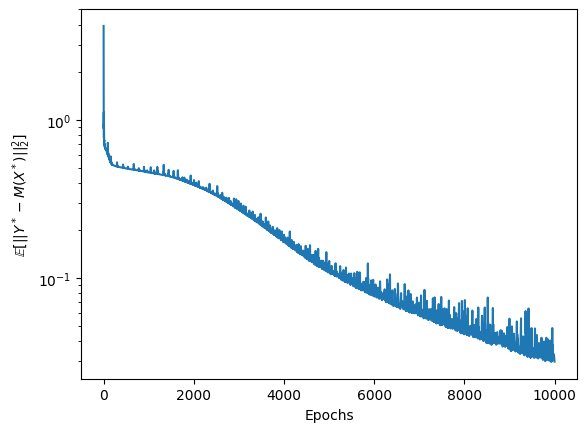

In [43]:
import torch
from torch import nn, optim

class Model(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.fc(x)
    
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=1))
        return loss

# Convert numpy array to pytorch tensors first
X = torch.tensor(X_ocd, dtype=torch.float32)
Y = torch.tensor(Y_ocd, dtype=torch.float32)

# Create NN by instantiating the model class
M = Model(input_dim=2)

# Set the optimizaiton method and learning rate
optimizer = optim.Adam(M.parameters(), lr=5e-3)

# Training loop
n_epochs = 10000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = M.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

M.eval()

# plot the training loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel(r"$\mathbb{E}[||Y^*-M(X^*)||_2^2]$")
plt.yscale("log")

Now, we can test the learned map $M:X\rightarrow Y$ by sampling $X$ (Gaussian) and checking density of $Y$ (Swiss roll).

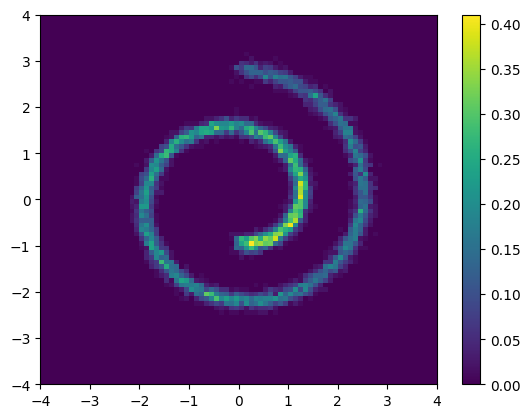

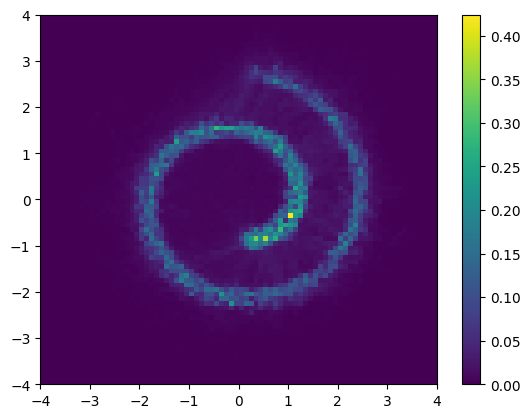

In [47]:
# generate testing samples
Xtest = np.random.normal(0,1,(10**6,2))
Xtest = torch.tensor(Xtest, dtype=torch.float32)
Ytest = M.forward(Xtest).detach().numpy()

plt.figure()
_ = plt.hist2d(Y00[:,0],Y00[:,1],bins=80, range=[[-4,4],[-4,4]], density=True)
plt.colorbar()

plt.figure()
_ = plt.hist2d(Ytest[:,0],Ytest[:,1],bins=80, range=[[-4,4],[-4,4]], density=True)
plt.colorbar()